<center> 
    <h1> 
        تمرین چهارم - سوال دوم
    <h2> 
        تشخیض اخبار جعلی

 <center>
    <h2> 
        Fake News Detection

<div style="text-align: right">
    <em>
        Authors : Parham Bicharanlu  - Anahita Hashemzadeh <br>
        Professors : Dr. kalhor <br>
    </em>
</div>

# 0. Imports 

In [894]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import re
from tqdm.notebook import tqdm
from datetime import datetime
from functools import reduce
from operator import add
from collections import Counter

import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))
from gensim.models.phrases import Phrases, Phraser
from string import punctuation
punctuation = list(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [895]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 1. Datasets first pre-proceessing

## 1.1. Verified news dataset

In [896]:
path = "/content/drive/MyDrive/Colab Notebooks/FA-KES-Dataset.csv"
print(path)

/content/drive/MyDrive/Colab Notebooks/FA-KES-Dataset.csv


In [897]:
df = pd.read_csv(path, encoding= 'unicode_escape')
df

,unit_id,article_title,article_content,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0
...,...,...,...,...,...,...,...
799,1965511221,Turkish Bombardment Kills 20 Civilians in Syria,28-08-2016 Turkish Bombardment Kills 20 Civili...,manar,8/28/2016,aleppo,1
800,1965511222,Martyrs as Terrorists Shell Aleppos Salah Eddin,17-08-2016 Martyrs as Terrorists Shell Aleppos...,manar,8/1/2016,aleppo,1
801,1965511224,Chemical Attack Kills Five Syrians in Aleppo SANA,03-08-2016 Chemical Attack Kills Five Syrians ...,manar,8/3/2016,aleppo,0
802,1965511226,5 Killed as Russian Military Chopper Shot down...,01-08-2016 5 Killed as Russian Military Choppe...,manar,8/1/2016,idlib,1


In [898]:
df.shape

(804, 7)

In [899]:
df.isna().sum()

unit_id            0
article_title      0
article_content    0
source             0
date               0
location           0
labels             0
dtype: int64

### 1.1.1. Text column
  

In [900]:
def most_common(corpus, nb_words):
  """
  Returns the chosen number of most common words in our corpus
  with their occurences number
  ------------
  Inputs : 
    corpus(pd.Series) : the corpus containing the text samples
    nb_words (int) : number of most common words to return 
  Outputs : 
    d[:nb_words] (pd.DataFrame) : most common words and their occurances in the corpus
  """
  articles = corpus.str.split()
  words = np.array([word for article in articles for word in article if word.lower() not in stopwords])
  counter = Counter(words)
  d = pd.DataFrame(counter, index=['occurrences']).transpose().reset_index()
  d.columns=['word', 'occurences']
  d = d.sort_values('occurences', ascending=False)
  return d[:nb_words]

In [901]:
most_common(df['article_content'], 10)

,word,occurences
47,Syrian,2545
359,killed,1941
21,said,1929
75,Aleppo,1296
4,Syria,1248
330,people,1188
126,civilians,965
432,regime,956
189,city,934
5,attack,848


check if we have any duplicates or blanck article

In [902]:
df['article_content'].value_counts()[df['article_content'].value_counts()>1]

18 November 2016 6 citizens killed 22 injured in terrorist attacks with shells in Damascus Aleppo and Idleb. The Takfiri terrorist organizations on Friday targeted with rocket and mortar shells the cities of Damascus and Aleppo and al-Fouaa town in Idleb. Damascus Terrorists of the so called Jaish al-Islam targeted with rocket shells a number of the residential neighborhoods in Damascus city. A source at Damascus Police Command said that terrorist groups positioned in the Eastern Ghouta targeted al-Salyhiah neighborhood killing a woman and injuring three others. The source added that other shells hit the neighborhoods of al-Mazzeh and Ruken Eddin and al-Mazra area causing material damage to private and public properties. Aleppo Death toll from terrorist rocket attacks on residential neighborhoods in Aleppo city rose to 5 killed and 17 injured. SANA reporter in Aleppo said that terrorists fired a rocket shell on Iskandaron Street in al-Jamilyeh neighborhood in Aleppo city killing 3 citi

In [903]:
df['article_content'].value_counts()[df['article_content'].value_counts()>1].sum() - 211

-184

drop duplicates articles.



In [904]:
df = df.drop_duplicates(subset=['article_content'], ignore_index=True)

In [905]:
df.shape

(789, 7)

Next step, we will simply add title and text column in the same column

In [906]:
#df['article'] = df['article_title'] + '.' + df['article_content']

In [907]:
#df['article'][0]

In [908]:
del df['article_title']
#del df['article_content']

In [909]:
df.head()

,unit_id,article_content,source,date,location,labels
0,1914947530,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0


### 1.1.2. Date column

We will check the length of each date value to check whether all data format are uniform.

In [910]:
df['date_len'] = [len(x) for x in df['date']]
print(df['date_len'].value_counts())
del df['date_len']

9     464
8     202
10    123
Name: date_len, dtype: int64


<ipython-input-910-bef68e313dad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_len'] = [len(x) for x in df['date']]


The date format seems to be the same. 

# 2. Explanatory Analysis

### 2.1. Source column

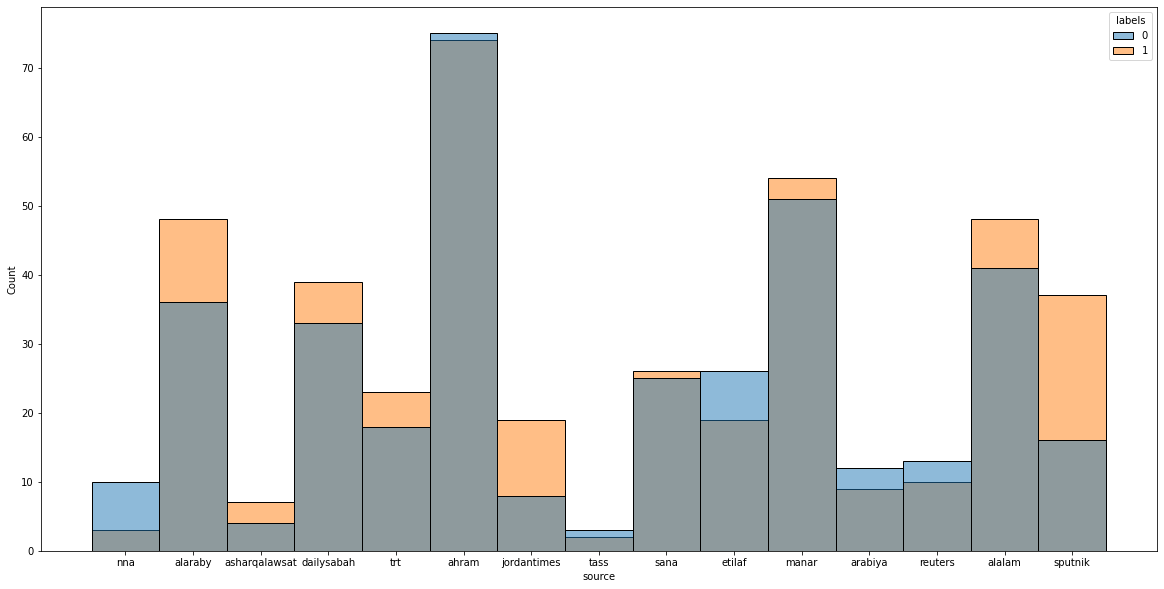

In [911]:
fig, hist = plt.subplots(figsize = (20,10))
hist = sns.histplot(data=df, x = 'source', hue="labels")
plt.savefig('histplot_source')

In [912]:
del df['source']

Although the source of the news can be useful according to the diagram, but because it is not used in the article, we will remove it

### 2.2. Date column

We also remove this column because it is not used in the article.

In [913]:
del df['date']

### 2.3. Text analysis and pre-processing

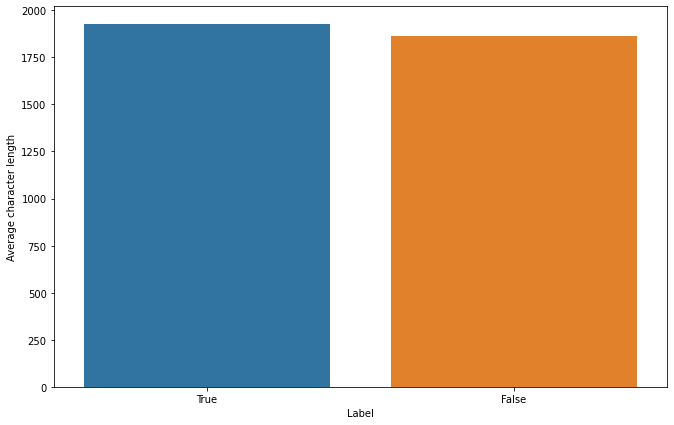

In [914]:
av_t = df[df['labels'] == 1]['article_content'].apply(lambda x: len(x)).mean()
av_f = df[df['labels'] == 0]['article_content'].apply(lambda x: len(x)).mean()
av = pd.DataFrame(data = {'Average character length': [av_t, av_f], 'Label':['True', 'False']})
fig, bar = plt.subplots(figsize = (11,7))
bar = sns.barplot(y='Average character length', x='Label',data=av, )

We can see that there is no striking difference between fake and true news for the average character length.

Text(0.5, 1.0, 'False texts')

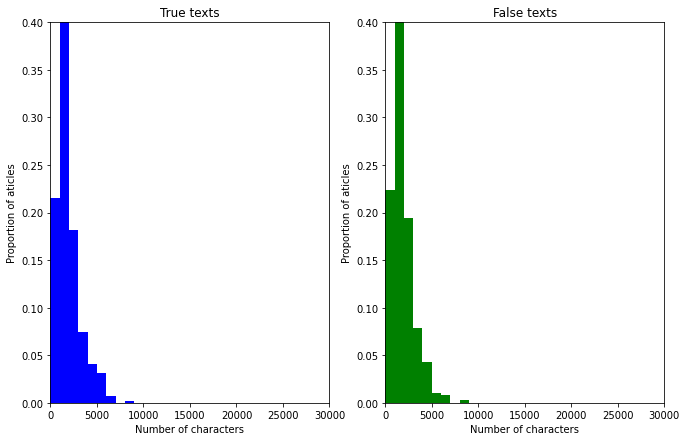

In [915]:
# Characters length of articles
len_cha_true = df[df['labels'] == 1]['article_content'].apply(lambda x: len(x))
len_cha_false = df[df['labels'] == 0]['article_content'].apply(lambda x: len(x))

bins_ = [i * 1000 for i in range(0,31)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_cha_true, bins = bins_, weights = np.ones(len(len_cha_true))/len(len_cha_true), color = 'b')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 30000)
hist1.set_xlabel('Number of characters')
hist1.set_ylabel('Proportion of aticles')
hist1.set_title('True texts')

hist2.hist(len_cha_false, bins = bins_, weights = np.ones(len(len_cha_false))/len(len_cha_false), color = 'g')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 30000)
hist2.set_xlabel('Number of characters')
hist2.set_ylabel('Proportion of aticles')
hist2.set_title('False texts')

Here again, we have no striking difference in the number of charcters : both fake and true news have most of the time less than 5000 charcters.even both have a same peak in 2000 characters. 

Text(0.5, 1.0, 'False texts')

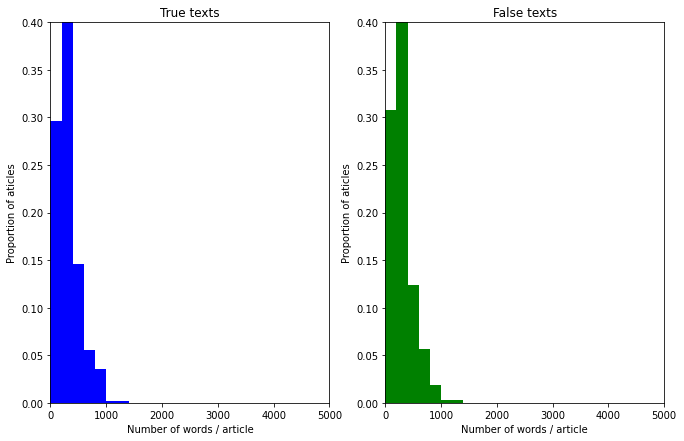

In [916]:
# Number of words per article
len_w_true = df[df['labels'] == 1]['article_content'].str.split().map(lambda x: len(x))
len_w_false = df[df['labels'] == 0]['article_content'].str.split().map(lambda x: len(x))


bins_ = [i * 200 for i in range(0,26)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_w_true, bins = bins_, weights = np.ones(len(len_w_true))/len(len_w_true), color = 'b')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 5000)
hist1.set_xlabel('Number of words / article')
hist1.set_ylabel('Proportion of aticles')
hist1.set_title('True texts')
hist2.hist(len_w_false, bins = bins_, weights = np.ones(len(len_w_false))/len(len_w_false), color = 'g')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 5000)
hist2.set_xlabel('Number of words / article')
hist2.set_ylabel('Proportion of aticles')
hist2.set_title('False texts')

We then proceed to a first cleaning of our articles. As we saw with some data exploration, we have a few html tags, urls, hastags and @ coming from tweets and square brackets (especially in the fake news dataset). We also decided to remove the stopwords and the punctuation from our articles.

In [917]:
stop = stopwords + punctuation + ['“','’', '“', '”', '‘','...']
tqdm.pandas()

def lowerizer(article):
  """
  Lowerize a given text
  ----
  Inputs : 
    article (str) : text to be pre-processed
  Outputs : 
    article.lower() (str) : lowerized text
  """
  return article.lower()

def remove_html(article):
    """
    Remove HTML tags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of HTML tags
    """
    article = re.sub("(<!--.*?-->)", "", article, flags=re.DOTALL)
    return article

def remove_url(article):
    """
    Remove URL tags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of URL tags
    """
    article = re.sub(r'https?:\/\/.\S+', "", article)
    return article

def remove_hashtags(article):
    """
    Remove hashtags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of hashtags
    """
    article = re.sub("#"," ",article)
    return article

def remove_a(article):
    """
    Remove twitter account references @ rom a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text withouttwitter account references 
    """
    article = re.sub("@"," ",article)
    return article

def remove_brackets(article):
    """
    Remove square brackets from a given text 
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text without square brackets
    """
    article = re.sub('\[[^]]*\]', '', article)
    return article

def remove_stop_punct(article):
    """
    Remove punctuation and stopwords from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text without punctuation or stopwords
    """
    final_article = []
    for i in article.split():
        if i not in stop:
            final_article.append(i.strip())
    return " ".join(final_article)

def preprocessing(article):
    """
    Computes the above-define steps to clean a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : pre-processed text
    """
    article = lowerizer(article)
    article = remove_html(article)
    article = remove_url(article)
    article = remove_hashtags(article)
    article = remove_a(article)
    article = remove_brackets(article)
    article = remove_stop_punct(article)
    return article

In [918]:
df['article_clean'] = df['article_content'].progress_apply(lambda x : preprocessing(x))

  0%|          | 0/789 [00:00<?, ?it/s]

<ipython-input-918-1a4305f65161>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['article_clean'] = df['article_content'].progress_apply(lambda x : preprocessing(x))


In [919]:
df

,unit_id,article_content,location,labels,article_clean
0,1914947530,Wed 05 Apr 2017 Syria attack symptoms consiste...,idlib,0,wed 05 apr 2017 syria attack symptoms consiste...
1,1914947532,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,homs,0,fri 07 apr 2017 0914 homs governor says u.s. a...
2,1914947533,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,aleppo,0,sun 16 apr 2017 death toll aleppo bomb attack ...
3,1914947534,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,aleppo,0,wed 19 apr 2017 aleppo bomb blast kills six sy...
4,1914947535,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,aleppo,0,sun 10 jul 2016 29 syria rebels dead fighting ...
...,...,...,...,...,...
784,1965511221,28-08-2016 Turkish Bombardment Kills 20 Civili...,aleppo,1,28-08-2016 turkish bombardment kills 20 civili...
785,1965511222,17-08-2016 Martyrs as Terrorists Shell Aleppos...,aleppo,1,17-08-2016 martyrs terrorists shell aleppos sa...
786,1965511224,03-08-2016 Chemical Attack Kills Five Syrians ...,aleppo,0,03-08-2016 chemical attack kills five syrians ...
787,1965511226,01-08-2016 5 Killed as Russian Military Choppe...,idlib,1,01-08-2016 5 killed russian military chopper s...


Lastly, we plot a few visual data presentation graphs : wordclouds for true and fake news to visually see the most frequent words as well as unigrams and bigrams for true and fake datasets to see these occurences.

In [920]:
from wordcloud import WordCloud,STOPWORDS
def wordcloud(corpus, title): 
  wordcloud = WordCloud(width = 1000, height = 500, stopwords=STOPWORDS, background_color='white').generate(" ".join(corpus))
  plt.figure(figsize=(15,8))
  plt.imshow(wordcloud)
  plt.title(title)
  plt.axis("off")
  plt.show()

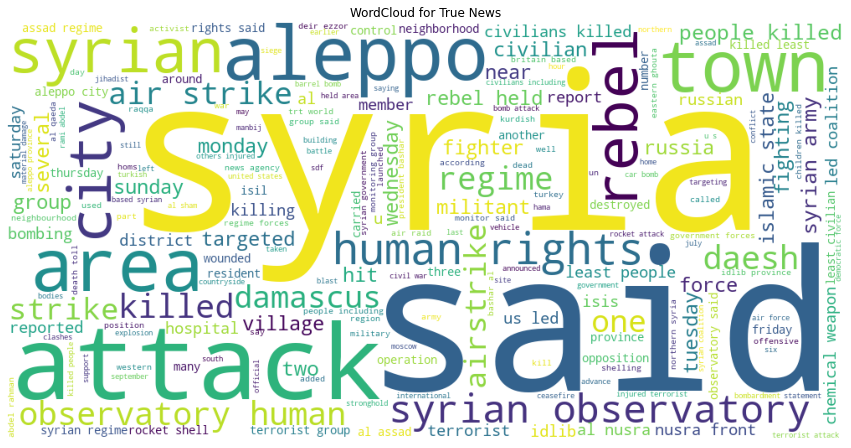

In [921]:
wordcloud(df[df['labels']==1]['article_clean'], "WordCloud for True News")

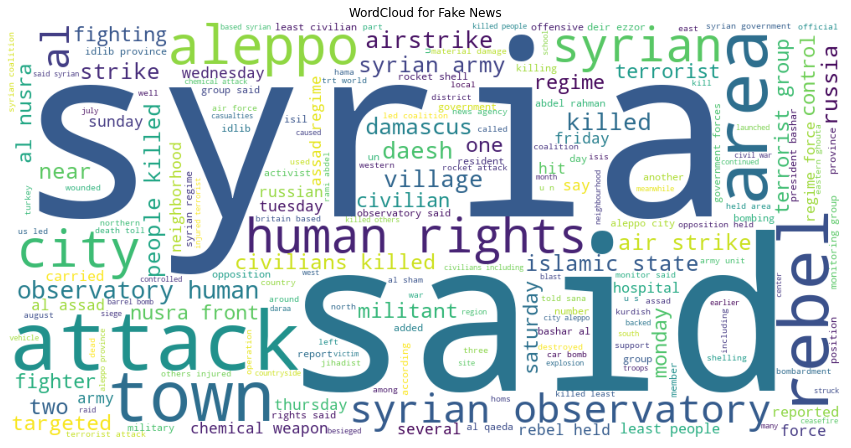

In [922]:
wordcloud(df[df['labels']==0]['article_clean'], "WordCloud for Fake News")

In [923]:
from sklearn.feature_extraction.text import CountVectorizer
def get_ngrams(corpus, nb_grams, nb_words):
    """
    Computes and return the chosen most n_grams of a corpus 
    ----
    Inputs : 
      corpus(pd.Serie) : given corpus of texts
      n (int) :  number of n_grams to dislay(most frequent)
      g (int) : number of n_grams
    Outputs : 
      article (str) : pre-processed text
    """
    count = CountVectorizer(ngram_range=(nb_grams, nb_grams)).fit(corpus)
    ensemble = count.transform(corpus).sum(axis=0)
    words_freq = [(word, ensemble[0, idx]) for word, idx in count.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:nb_words]

In [924]:
def plot_ngrams(get_top_text_ngrams_output, title, n, num_to_show=20):
  """
  Returns a line plot with occurence count on the absciss and num_to_show most frequent int_n-grams on the ordinate
  ------------
  Inputs : 
    get_top_text_ngrams_output(list of tuples) : list containing the most frequent n-grams and their occurrences
    title (str) : titre du graphique
    n (int) : bigrams (2), trigrams (3), etc.
    num_to_show (int) : number of most common words to return 
  Outputs : 
    matplotlib line plot : most common n-grams and their occurrences in the corpus
  """
  df = pd.DataFrame(get_top_text_ngrams_output, columns=['ngram', 'count'])
    
  counts, word = df['count'], df['ngram']
  zipped_lists = zip(counts, word)
  sorted_pairs = sorted(zipped_lists)

  tuples = zip(*sorted_pairs)
  counts, word = [ list(tuple) for tuple in  tuples]

  plt.figure(figsize=[6,10])
  plt.plot(counts[-num_to_show:], word[-num_to_show:],lw=5,c='b')
  plt.ylabel('{}-grams'.format(n),fontsize=20)
  plt.yticks(fontsize=14)
  plt.xlabel('Occurrence count',fontsize=20)
  plt.xticks(fontsize=14)
  plt.show()

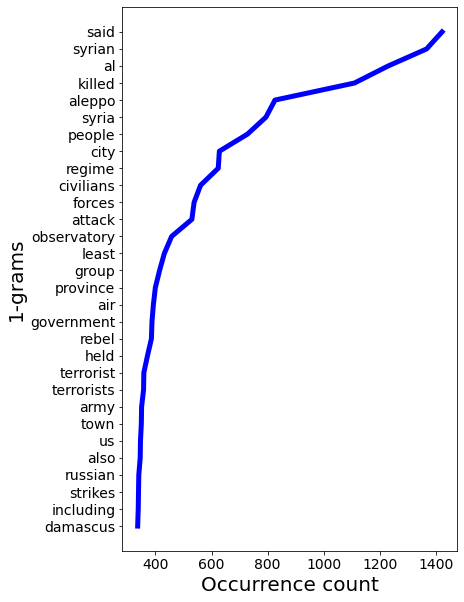

In [925]:
b = get_ngrams(df[df['labels']==1]['article_clean'],1,30)
plot_ngrams(b,"Unigram for True News" , 1, num_to_show=30)

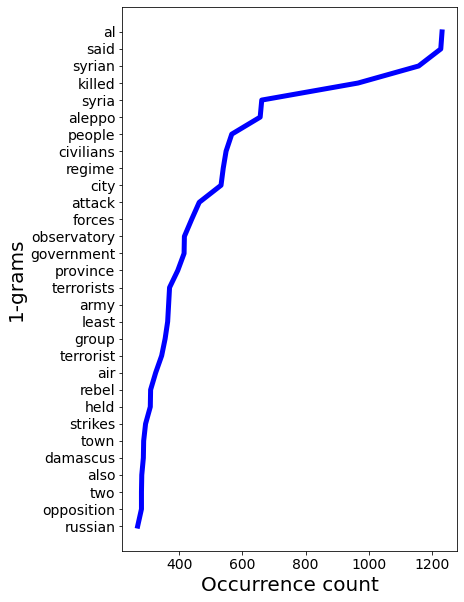

In [926]:
b = get_ngrams(df[df['labels']==0]['article_clean'],1,30)
plot_ngrams(b,"Unigram for Fake News", 1, num_to_show=30)

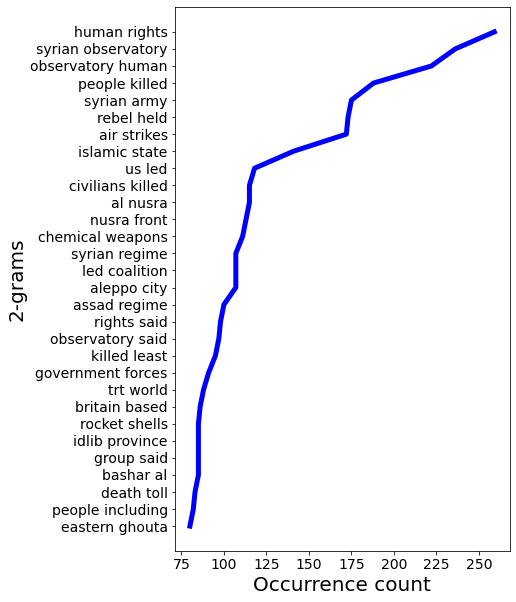

In [927]:
# label is 1
b = get_ngrams(df[df['labels']==1]['article_clean'],2,30)
plot_ngrams(b,"Bigrams for True News", 2, num_to_show=30)

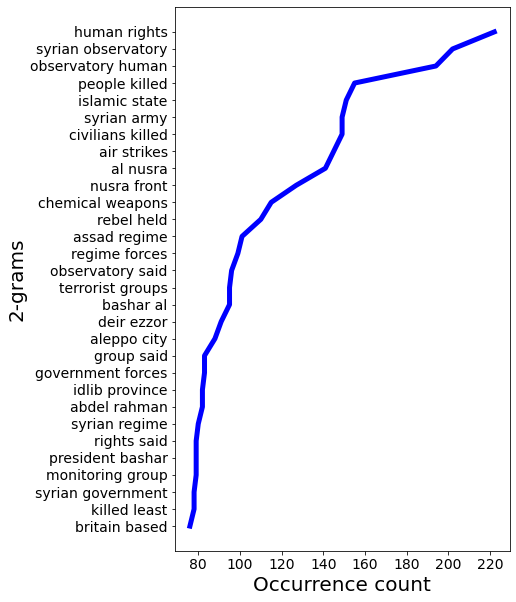

In [928]:
b = get_ngrams(df[df['labels']==0]['article_clean'],2,30)
plot_ngrams(b,"Bigram for Fake News", 2, num_to_show=30)

# 3. Model prediction

## 3.1. Data Preparation

In [929]:
import torch
from torch import nn
import torch.optim as optim
import nltk
from nltk import word_tokenize
nltk.download('punkt')
from torch.nn.utils.rnn import pad_sequence
import random
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Firstly, we define a function to help us split our dataset into training, validation and testing datasets split between our cleaned articles and the labels

In [930]:
def get_splits(x, y, splits):
  """
  Split the features and target variables into training, validation and testing datasets 
  ------
  Inputs : 
    x (pd.Serie) : cleaned articles 
    y (pd.Serie) : target variable
    splits (floats tuple) : proportion of training and validation samples 
  Outputs : 
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) (numpy arrays) : splitted datasets between training features and targets, validation features and targets, testing features and targets
  """
    # Create an index list and shuffle it
  n = len(x)
  indexes = np.arange(n)
  random.shuffle(indexes)

  # Find the two indexes we'll use to cut the lists from the splits
  valid_begin = int(splits[0]*n)
  test_begin = valid_begin + int(splits[1]*n)
  
  # We process the splitting using our defined indexes
  train_x, train_y = np.array(x)[indexes[:valid_begin]], np.array(y)[indexes[:valid_begin]]
  valid_x, valid_y = np.array(x)[indexes[valid_begin:test_begin]], np.array(y)[indexes[valid_begin:test_begin]]
  test_x, test_y = np.array(x)[indexes[test_begin:]], np.array(y)[indexes[test_begin:]]
  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [931]:
splits = (0.8, 0.1)
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = get_splits(df['article_clean'], df['labels'], splits)
(len(train_x), len(train_y)), (len(valid_x), len(valid_y)), (len(test_x), len(test_y))


((631, 631), (78, 78), (80, 80))

In [932]:
def distribution_data(corpus): 
  """
  Returns number of fake and true news in a given dataset
  ----
  Inputs : 
    corpus (array) : labels of our dataset
  Outputs : 
    distrib (pd.DataFrame) : number of true and fake news in the dataset 
  """
  nb_true = corpus.sum()
  nb_false = len(corpus) - nb_true
  distrib = pd.DataFrame(data = {'Number of samples': [nb_true, nb_false], 'Label':['True', 'False']})
  return distrib

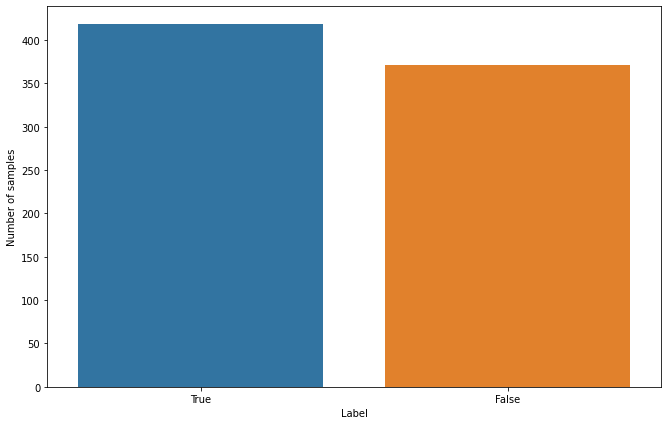

In [933]:
distrib = distribution_data(df['labels'])
fig, bar = plt.subplots(figsize = (11,7))
bar = sns.barplot(y='Number of samples', x='Label',data=distrib)

As we can see, our dataset is rather balanced between the number of fake and true news. 

In [934]:
train_distrib = distribution_data(train_y)
valid_distrib = distribution_data(valid_y)
test_distrib = distribution_data(test_y)

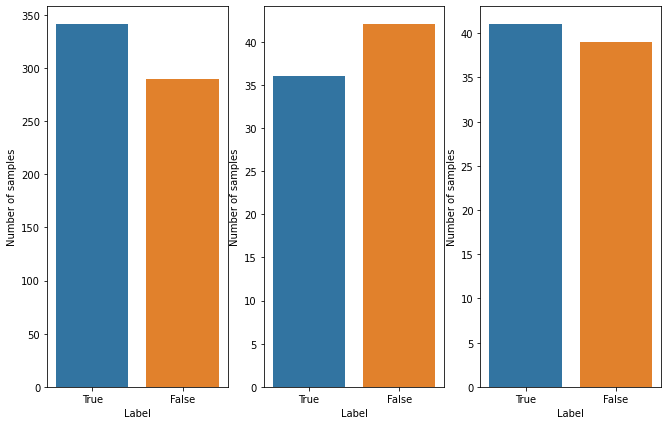

In [935]:
fig, (bar1, bar2, bar3) = plt.subplots(1,3, figsize = (11,7))
sns.barplot(y='Number of samples', x='Label',data=train_distrib, ax = bar1)
sns.barplot(y='Number of samples', x='Label',data=valid_distrib, ax = bar2)
sns.barplot(y='Number of samples', x='Label',data=test_distrib, ax = bar3)

same class represnetation in the train, validation and test datasets so that there is no bias. 

We then define a function inheriting the Dataset module from pytorch. This helps to build the vocabulary from our traning dataset and builds dictionnary from index to word and from word to index of this vocabulary. Then we process our cleaned articles with a few preliminary steps such as tokenizing using nltk, transpose the words of articles into indexes, pass them as tensor and only keep the determined length. Lastly, we pad the sequence to have uniform length across our samples. 

In [936]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = 300, min_freq = 5):
        
        self.data = data
        self.max_length = max_length
        
        # Allow to import a vocabulary (validation and testing will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # Build the vocabulary if none is imported
            self.word2idx, self.idx2word = self.build_vocab(self.data, min_freq)
        
        # We tokenize the articles
        tokenized_data = [word_tokenize(file.lower()) for file in self.data]
        # Transform words into lists of indexes
        indexed_data = [[self.word2idx.get(word, self.word2idx['UNK']) for word in file] for file in tokenized_data]
        # Transform into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(file) for file in indexed_data]
        # Lables are passed into a FloatTensor
        tensor_y = torch.FloatTensor(categories)
        # Finally we cut too the determined maximum length
        cut_tensor_data = [tensor[:max_length] for tensor in tensor_data]
        # We pad the sequences to have the whole dataset containing sequences of the same length
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=0)
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, count_threshold):
        word_counts = {}
        for sent in corpus:
            for word in word_tokenize(sent.lower()):
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1   
        filtered_word_counts = {word: count for word, count in word_counts.items() if count >= count_threshold}        
        words = sorted(filtered_word_counts.keys(), key=word_counts.get, reverse=True) + ['UNK']
        word_index = {words[i] : (i+1) for i in range(len(words))}
        idx_word = {(i+1) : words[i] for i in range(len(words))}
        return word_index, idx_word
    
    def get_vocab(self):
        return self.word2idx, self.idx2word

Then we use our newly defined class to prepare the training data, build our vocabulary from the training dataset and then prepare our valisation and testing dataset. 

In [937]:
training_dataset = TextClassificationDataset(train_x, train_y)
training_word2idx, training_idx2word = training_dataset.get_vocab()
valid_dataset = TextClassificationDataset(valid_x, valid_y, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(test_x, test_y, (training_word2idx, training_idx2word))

We then pass our datasets to DataLoader which combines a dataset and a sampler, and provides an iterable over the given dataset. This will shuffle the datasets and provide iterable object of batches. 



In [938]:
training_dataloader = DataLoader(training_dataset, batch_size = 64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 4)
test_dataloader = DataLoader(test_dataset, batch_size = 4)

## 3.2. Embeddings & Model Design

GloVe embedding with an embedding dimension of 100 features per word vector.

In [939]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-100")
loaded_glove_embeddings = loaded_glove_model.vectors

In [940]:
def get_glove_adapted_embeddings(glove_model, input_voc):
  """
  Retrieve a vocabulary words'embeddings from GloVe 
  ----
  Inputs : 
    glove_model () : GloVe Embedding model
    input_voc (dict) : dictionnary of our indexed vocabulary 
  Outputs : 
    embeddings (ndarray) : GloVe Embeddings for the given vocabulary with the vocabulary index
  """
  keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
  index_dict = {i: key.index for i, key in keys.items() if key is not None}
  embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
  for i, ind in index_dict.items():
      embeddings[i] = glove_model.vectors[ind]
  return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

Then we define our model. We decided to define a rather simple model for our task : after the embedding layer of dim (vocab_size, 300), we stack two LSTM layers with hidden_size of 256. We also enable to load our GloVe vectors as embeddings and the possibility to fine_tune those embedding on our data. Lastly, we have a fully connected layer. 

## 3.3. Training

### 3.3.1. Functions definition

We define a few functions first to help use with the training : 

*   <b><code>train_epochs</code></b> : iterates through the DataLoader object created with the training dataset and computes a pass (forward, loss, backward, weights update) on each batch of the DataLoader with metrics calculation.
*   <b><code>eval_model</code></b> : iterates through the DataLoader object created with the validation or testing dataset and computes a forward pass on each batch of the DataLoader with metrics calculation. 
*   <b><code>experiment</code></b> : iterates through the defined number of epochs (pass over whole data). For each one, we train thanks to the train_epoch function over the batches of the training datasets, at the end of each epoch, we evaluate on the validation dataset with eval_model and at the end of the training (all epochs done), evaluate on the test dataset. We store the loss, accuracy computations for all batches of all epochs for the training dataset, and for all epochs on the validation dataset. We don't store the accuraccy and loss computed on the test dataset but we keep the made predictions thanks to the test dataset.

In [941]:
def train_epoch(model, opt, criterion, dataloader):
  """
  Trains the mode over an epoch 
  ----
  Inputs : 
    model () : defined model to be trained
    opt () : chosen and defined optimizer 
    criterion () : chosen and defined loss
    dataloader() : iterable object with the batches
  Outputs : 
    losses (list) : list of training loss for each batch of the epoch
    accs (list) : list of training accuracy for each batch of the epoch
  """
  model.train()
  losses = []
  accs = []
  for i, (x, y) in enumerate(dataloader):
      opt.zero_grad()
      # Forward pass
      pred = model(x)
      #print('y:',y)
      #print('pred:',pred)
      # Loss Computation
      loss = criterion(pred, y)
      # Backward pass
      loss.backward()
      # Weights update
      opt.step()
      losses.append(loss.item())
      # Compute accuracy
      num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
      acc = 100.0 * num_corrects/len(y)
      accs.append(acc.item())
      if (i%20 == 0):
          print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
  return losses, accs

In [942]:
def eval_model(model, criterion, evalloader):
  """
  Evaluate the model  
  ----
  Inputs : 
    model () : defined model to be trained
    criterion () : chosen and defined loss
    evalloader() : iterable object with the batches 
  Outputs : 
    total_epoch_loss/(i+1) (float) : computed loss 
    total_epoch_acc/(i+1) (float) : computed accuracy 
    preds (list) : predictions made by the model
  """
  model.eval()
  total_epoch_loss = 0
  total_epoch_acc = 0
  preds = []
  with torch.no_grad():
      for i, (x, y) in enumerate(evalloader):
          pred = model(x)
          loss = criterion(pred, y)
          num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
          acc = 100.0 * num_corrects/len(y)
          total_epoch_loss += loss.item()
          total_epoch_acc += acc.item()
          preds.append(pred)

  return total_epoch_loss/(i+1), total_epoch_acc/(i+1), preds

In [943]:
def experiment(model, opt, criterion, num_epochs = 5):
  """
  Trains & Evaluates the model over all epochs 
  ----
  Inputs : 
    model () : defined model to be trained
    opt () : chosen and defined optimizer 
    criterion () : chosen and defined loss
    num_epochs() : chosen number of epochs to go through
  Outputs : 
    train_losses (list): training losses of all batches for each epochs
    valid_losses (list): losses over vaidation data for all epochs
    test_loss (list): loss over test data once the model is trained 
    train_accs (list): training accuracies of all batches for each epochs
    valid_accs (list): accuracies over vaidation data for all epochs
    test_acc (list): accuracy over test data once the model is trained
    test_preds (): predictions on test dataset
  """
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []
  print("Beginning training...")
  for e in range(num_epochs):
      print("Epoch " + str(e+1) + ":")
      print('train--')
      losses, accs = train_epoch(model, opt, criterion, training_dataloader)
      train_losses.append(losses)
      train_accs.append(accs)
      print('val--')
      valid_loss, valid_acc, val_preds = eval_model(model, criterion, valid_dataloader)
      valid_losses.append(valid_loss)
      valid_accs.append(valid_acc)
      print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
  print('test--')
  test_loss, test_acc, test_preds = eval_model(model, criterion, test_dataloader)
  print("Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
  return train_losses, valid_losses, test_loss, train_accs, valid_accs, test_acc, test_preds

In [944]:
EMBEDDING_DIM = 100 
VOCAB_SIZE = len(training_word2idx)
HIDDEN_DIM = 256
learning_rate = 0.0025
num_epochs = 10

## model: RNN

In [945]:
class LSTMModel(nn.Module):

    def __init__(self, embedding_dim, vocabulary_size, hidden_dim, embeddings=None, fine_tuning=False):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        if embeddings:
            self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(GloveEmbeddings), freeze=not fine_tuning, padding_idx=0)
        else:
            self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1, embedding_dim=embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(in_features=2*hidden_dim, out_features=1)
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU(inplace = True)

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        lstm_out, (ht, ct) = self.lstm(emb, None)
        h = torch.cat((ht[-2], ht[-1]), dim=1)
        h = self.relu(h)
        x = torch.squeeze(self.linear(h))
        return x

In [946]:
model_lstm = LSTMModel(100, len(training_word2idx), 16, 32, fine_tuning=True)
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

In [947]:
model_lstm

LSTMModel(
  (embeddings): Embedding(2920, 100, padding_idx=0)
  (lstm): LSTM(100, 16, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
  (sig): Sigmoid()
  (relu): ReLU(inplace=True)
)

In [948]:
num_epochs= 10
train_losses_rnn, valid_losses_rnn, test_loss_rnn, train_accs_rnn, valid_accs_rnn, test_acc_rnn, test_preds_rnn = experiment(model_lstm, optimizer, criterion, num_epochs)

Beginning training...
Epoch 1:
train--
Batch 0 : training loss = 0.6997811794281006; training acc = 50.0
val--
Epoch 1 : Validation loss = 0.7036371827125549; Validation acc = 46.25
Epoch 2:
train--
Batch 0 : training loss = 0.6960296630859375; training acc = 50.0
val--
Epoch 2 : Validation loss = 0.702810314297676; Validation acc = 46.25
Epoch 3:
train--
Batch 0 : training loss = 0.6967533826828003; training acc = 48.4375
val--
Epoch 3 : Validation loss = 0.7023432642221451; Validation acc = 46.25
Epoch 4:
train--
Batch 0 : training loss = 0.6766441464424133; training acc = 60.9375
val--
Epoch 4 : Validation loss = 0.7026429235935211; Validation acc = 46.25
Epoch 5:
train--
Batch 0 : training loss = 0.6968250870704651; training acc = 48.4375
val--
Epoch 5 : Validation loss = 0.7022483497858047; Validation acc = 46.25
Epoch 6:
train--
Batch 0 : training loss = 0.6808370351791382; training acc = 57.8125
val--
Epoch 6 : Validation loss = 0.7025557696819306; Validation acc = 46.25
Epoch 7

In [949]:
print(len(train_accs_rnn[0]))
print(len(valid_accs_rnn))
print(len(train_accs_rnn))
print(valid_accs_rnn)
print(train_accs_rnn[0])

10
10
10
[46.25, 46.25, 46.25, 46.25, 46.25, 46.25, 46.25, 46.25, 46.25, 46.25]
[50.0, 64.0625, 54.6875, 53.125, 53.125, 56.25, 45.3125, 56.25, 59.375, 47.272727966308594]


In [950]:
train_losses_model = [mean(train_loss) for train_loss in train_losses_rnn]
train_accs_model = [mean(train_acc) for train_acc in train_accs_rnn]

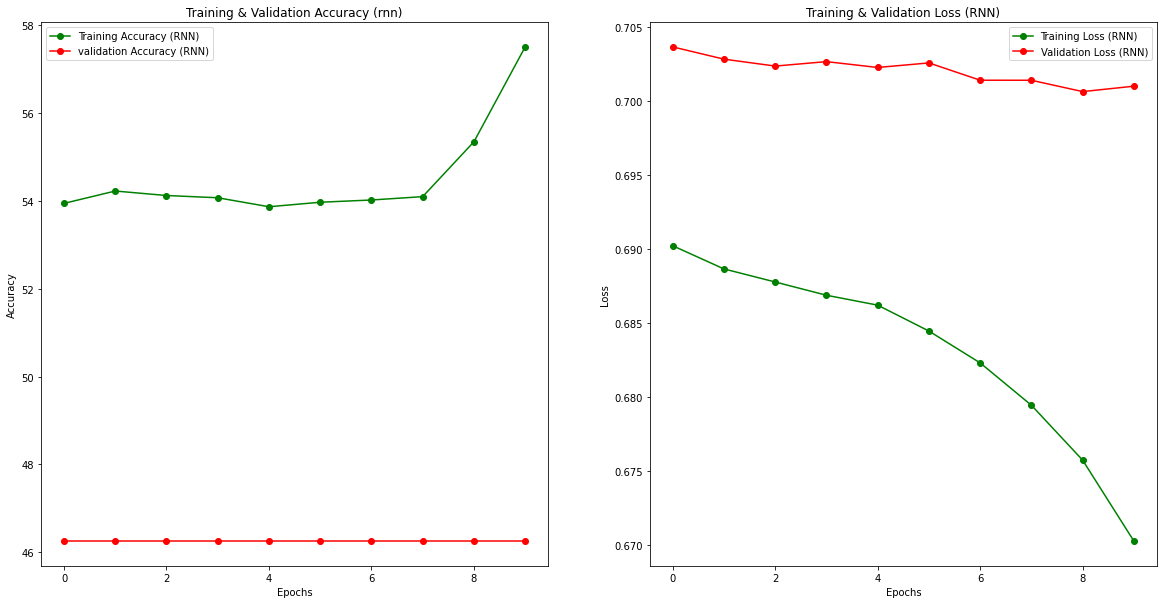

In [951]:
epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs_model , 'go-' , label = 'Training Accuracy (RNN)')
ax[0].plot(epochs , valid_accs_rnn , 'ro-' , label = 'validation Accuracy (RNN)')
ax[0].set_title('Training & Validation Accuracy (rnn)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses_model , 'go-' , label = 'Training Loss (RNN)')
ax[1].plot(epochs , valid_losses_rnn , 'ro-' , label = 'Validation Loss (RNN)')
ax[1].set_title('Training & Validation Loss (RNN)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.savefig('acc_loss_rnn')
plt.show()

In [952]:
preds_rnn = [(torch.sigmoid(t)>0.5).tolist() for t in test_preds_rnn]
preds_rnn = [int(t2) for el2 in preds_rnn for t2 in el2]

In [953]:

from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(preds_rnn,test_y)
cm3_ = pd.DataFrame(cm3 , index = ['True','Fake'] , columns = ['True','Fake'])

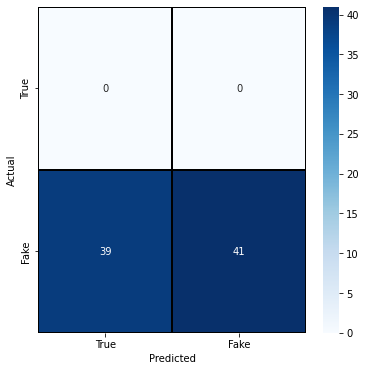

In [954]:
plt.figure(figsize = (6,6))
sns.heatmap(cm3,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['True','Fake'] , yticklabels = ['True','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('conf_rnn')


In [955]:
from sklearn.metrics import classification_report
print(classification_report(test_y, preds_rnn, target_names = ['Predicted Fake','Predicted True']))

                precision    recall  f1-score   support

Predicted Fake       0.00      0.00      0.00        39
Predicted True       0.51      1.00      0.68        41

      accuracy                           0.51        80
     macro avg       0.26      0.50      0.34        80
  weighted avg       0.26      0.51      0.35        80



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.3.3. model : Hybrid CNN and LSTM

In [956]:
from torch.nn import functional as F

class Hybrid_CNN_LSTM(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, window_size: int = 16, filter_multiplier = 64, embeddings = None, fine_tuning = False):
      super().__init__()
      self.embedding_dim = embedding_dim 
      if embeddings:
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(GloveEmbeddings), freeze=not fine_tuning, padding_idx=0)

      else:
        self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1, embedding_dim=embedding_dim, padding_idx=0)

      self.conv1d = nn.Conv1d(300, 128, kernel_size=5)
      self.dropout = nn.Dropout(0.2)
      self.linear = nn.Linear(filter_multiplier, 1)
      self.maxpooling1d = nn.MaxPool1d(kernel_size=2,stride= 2)
      self.lstm = nn.LSTM(input_size=48, hidden_size=32, batch_first=True, num_layers=1)
      self.linear = nn.Linear(in_features=32, out_features=1)

    def forward(self, inputs):
      #print('inp shape:',inputs.shape)
      x = self.embeddings(inputs)
      #print('emb shape:',x.shape)
      #x = x.permute(0, 2, 1)
      x = self.conv1d(x)
      #print('conv shape:',x.shape)
      x = F.relu(x)
      x = self.maxpooling1d(x)
      #print('maxpool shape:',x.shape)
      x, (ht,ct) = self.lstm(x)
      x = x[:, -1, :]
      x= self.dropout(x)
      #print('lstm shape:',x.shape)
      #print('lstm ht shape:',ht.shape)
      x = self.linear(x)
      x = x[:, -1]
      #print('linear shape:',x.shape)
      x = F.sigmoid(x)

      #output = torch.squeeze(self.linear(x))

      return x

We keep a similar Adam optimizer with parameters displayed below and the same Binary Cross Entropy Loss. 

In [957]:
model_cnn_lstm = Hybrid_CNN_LSTM(100, len(training_word2idx), 16, 64, embeddings = True, fine_tuning=True)
optimizer = optim.Adam(model_cnn_lstm.parameters(), lr=0.0001, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

In [958]:
model_cnn_lstm

Hybrid_CNN_LSTM(
  (embeddings): Embedding(2920, 100, padding_idx=0)
  (conv1d): Conv1d(300, 128, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=32, out_features=1, bias=True)
  (maxpooling1d): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(48, 32, batch_first=True)
)

In [959]:
num_epochs= 10
train_losses, valid_losses, test_loss, train_accs, valid_accs, test_acc, test_preds = experiment(model_cnn_lstm, optimizer, criterion, num_epochs)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Beginning training...
Epoch 1:
train--
Batch 0 : training loss = 0.6761744022369385; training acc = 59.375
val--
Epoch 1 : Validation loss = 0.7369201630353928; Validation acc = 46.25
Epoch 2:
train--
Batch 0 : training loss = 0.6904067993164062; training acc = 56.25
val--
Epoch 2 : Validation loss = 0.7360327243804932; Validation acc = 46.25
Epoch 3:
train--
Batch 0 : training loss = 0.7468462586402893; training acc = 43.75
val--
Epoch 3 : Validation loss = 0.7352450489997864; Validation acc = 46.25
Epoch 4:
train--
Batch 0 : training loss = 0.7464902400970459; training acc = 43.75
val--
Epoch 4 : Validation loss = 0.7343434929847718; Validation acc = 46.25
Epoch 5:
train--
Batch 0 : training loss = 0.6970030069351196; training acc = 54.6875
val--
Epoch 5 : Validation loss = 0.7334791451692582; Validation acc = 46.25
Epoch 6:
train--
Batch 0 : training loss = 0.6820563673973083; training acc = 57.8125
val--
Epoch 6 : Validation loss = 0.732485157251358; Validation acc = 46.25
Epoch 7:

In [960]:
import statistics 
from statistics import mean
train_losses_hyb = [mean(train_loss) for train_loss in train_losses]
train_accs_hyb = [mean(train_acc) for train_acc in train_accs]

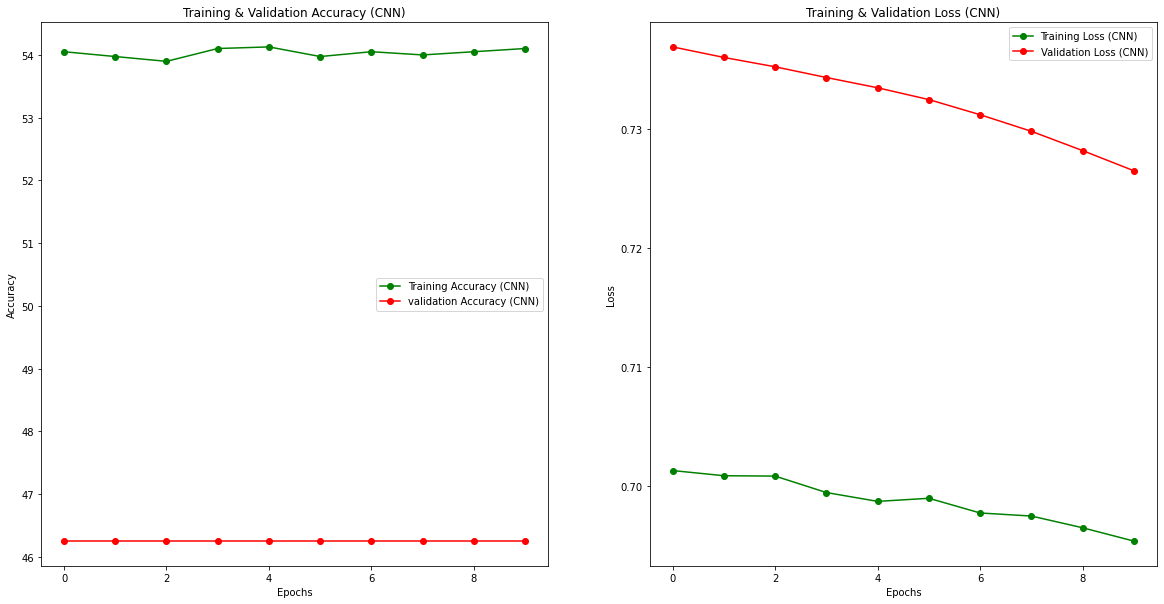

In [961]:
epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs_hyb , 'go-' , label = 'Training Accuracy (CNN)')
ax[0].plot(epochs , valid_accs , 'ro-' , label = 'validation Accuracy (CNN)')
ax[0].set_title('Training & Validation Accuracy (CNN)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses_hyb , 'go-' , label = 'Training Loss (CNN)')
ax[1].plot(epochs , valid_losses , 'ro-' , label = 'Validation Loss (CNN)')
ax[1].set_title('Training & Validation Loss (CNN)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.savefig('acc_loss_lstmcnn')
plt.show()

It seems that our CNN-based model overfit (training accuracy significantly higher than the LSTM-based model and the loss significantly lower). Thus it seems that this model isn't well suited and we will continue with the Evaluation of our LSTM-based model.

In [962]:
preds = [(torch.sigmoid(t)>0.5).tolist() for t in test_preds]
preds = [int(t) for el in preds for t in el]

In [963]:
preds[:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [964]:
test_y[:20]

array([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1])

In [965]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(preds,test_y)
cm_ = pd.DataFrame(cm , index = ['True','Fake'] , columns = ['True','Fake'])

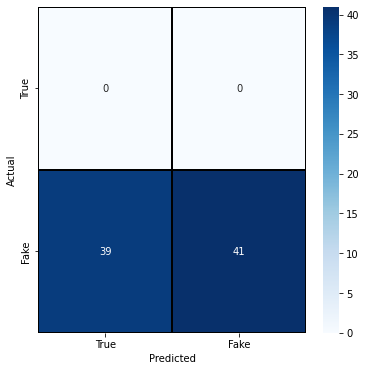

In [966]:
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['True','Fake'] , yticklabels = ['True','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('conf_hybrid')




*   **True Positives :** True News given as such by the model
*   **True Negative :** Fake News given as such by the model
*   **False Positive :** Fake News given as true by the model : dangerous as it can lead to a certified publication thus ensuring trust whereas it spread fake informations to the public. 
*   **False Negative :** True News given as Fake by the model. Can be seen as 

In [967]:
from sklearn.metrics import classification_report
print(classification_report(test_y, preds, target_names = ['Predicted Fake','Predicted True']))

                precision    recall  f1-score   support

Predicted Fake       0.00      0.00      0.00        39
Predicted True       0.51      1.00      0.68        41

      accuracy                           0.51        80
     macro avg       0.26      0.50      0.34        80
  weighted avg       0.26      0.51      0.35        80



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Lastly, we propose to inspect two misclassified sample of our test set to see if anything striking comes up. 